In [1]:
import pandas as pd

In [2]:
problem = 'Ghosts'
train = pd.read_csv('data/' + problem + '/train.csv')
test =  pd.read_csv('data/' + problem + '/test.csv')

In [3]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


# Visualization

In [4]:
from sklearn import preprocessing
color_encoder = preprocessing.LabelEncoder()

train.color = color_encoder.fit_transform(train.color)
test.color = color_encoder.transform(test.color)

train.head(2)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,3,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,4,Goblin


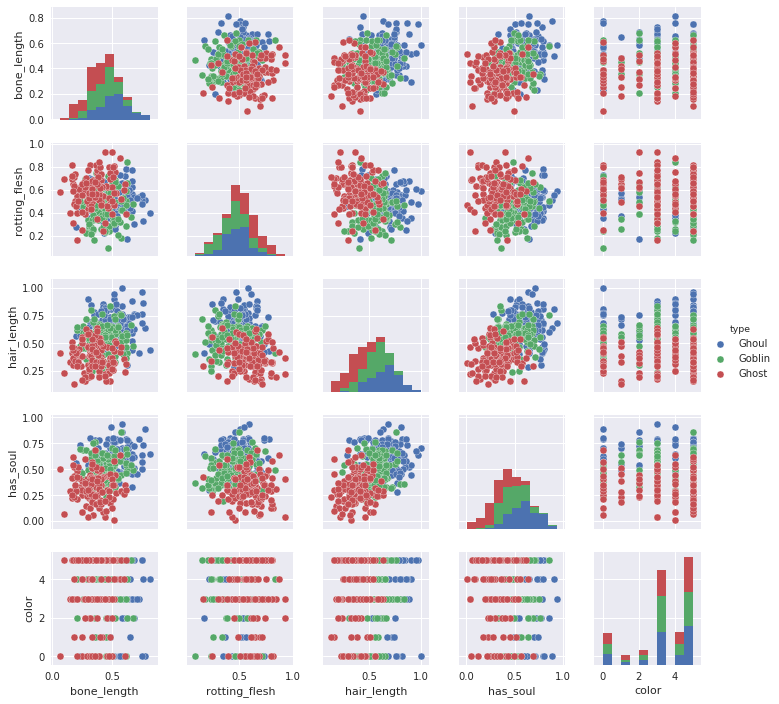

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

sns.pairplot(train.drop('id', axis=1), size=2, hue='type')

# Data preprocessing

In [6]:
X = train.drop(['id', 'type'], axis=1)
X.head(2)

,bone_length,rotting_flesh,hair_length,has_soul,color
0,0.354512,0.350839,0.465761,0.781142,3
1,0.575560,0.425868,0.531401,0.439899,4


In [7]:
X_test = test.drop(['id'], axis=1)

In [8]:
y = train.type
y.head(2)

0     Ghoul
1    Goblin
Name: type, dtype: object

In [9]:
answers_encoder = preprocessing.LabelEncoder()
y = answers_encoder.fit_transform(y)
y[:5] # вместо строк получились метки классов

array([1, 2, 1, 1, 0])

In [10]:
answers_encoder.classes_ # - здесь наши классы все еще лежат

array(['Ghost', 'Ghoul', 'Goblin'], dtype=object)

In [11]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85)

# 1. Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import model_selection

degree = 1

logfit = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('poly_features', preprocessing.PolynomialFeatures(degree)), 
    ('clf', LogisticRegression())])

scores = model_selection.cross_val_score(logfit, X_train, y_train, cv=5)
print('logfit score: %s' % scores.mean())

logfit.fit(X_train, y_train);

logfit score: 0.720302099334


# 2. KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

params = { 
    'n_neighbors': [x for x in range(1,100)],
    'weights': ['uniform', 'distance'],
    'p': [1,2],
}

knn = model_selection.GridSearchCV(KNeighborsClassifier(), param_grid=params)
knn.fit(X_train, y_train);

print('Best params for knn: ', knn.best_params_)
print('Best score: ', knn.best_score_)

Best params for knn:  {'weights': 'uniform', 'n_neighbors': 36, 'p': 1}
Best score:  0.75873015873


# 3. Classifier analysis

### Classification report

In [15]:
from sklearn import metrics

def print_report(y_pred):
    print(metrics.classification_report(y_validation, y_pred, target_names=answers_encoder.classes_))

In [16]:
logfit_pred = logfit.predict(X_validation)
print_report(logfit_pred)

             precision    recall  f1-score   support

      Ghost       0.83      0.95      0.89        21
      Ghoul       0.82      0.90      0.86        20
     Goblin       0.80      0.53      0.64        15

avg / total       0.82      0.82      0.81        56



In [17]:
knn_pred = knn.predict(X_validation)
print_report(knn_pred)

             precision    recall  f1-score   support

      Ghost       0.83      0.71      0.77        21
      Ghoul       0.83      0.75      0.79        20
     Goblin       0.45      0.60      0.51        15

avg / total       0.73      0.70      0.71        56



### ROC curve and ROC AUC

In [18]:
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_pred):
    y_score = preprocessing.label_binarize(y_pred, classes=[0, 1, 2])
    y_val = preprocessing.label_binarize(y_validation, classes=[0, 1, 2])

    n_classes = 3
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(answers_encoder.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of ROC to multi-class')
    plt.legend(loc="lower right")
    plt.show()

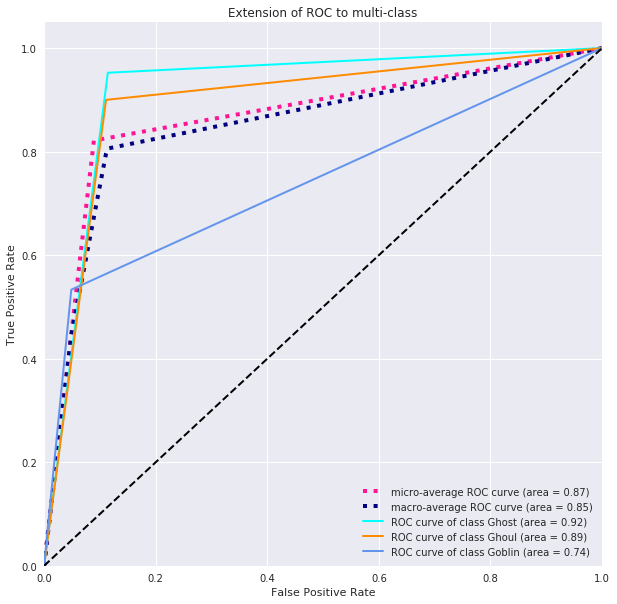

In [19]:
plot_roc_auc(logfit_pred)

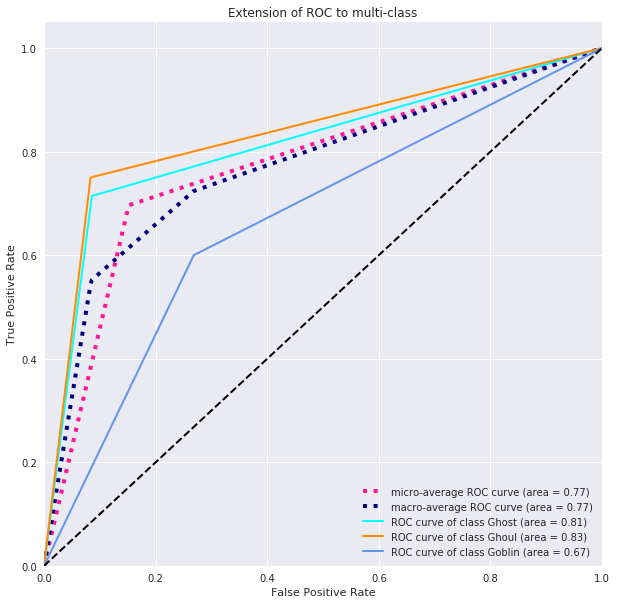

In [20]:
plot_roc_auc(knn_pred)

### Confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix

def plot_conf(y_pred):
    cm = pd.DataFrame(confusion_matrix(y_validation, y_pred),
                      index=answers_encoder.classes_,
                      columns=answers_encoder.classes_)
    sns.heatmap(cm, annot=True, fmt="d")

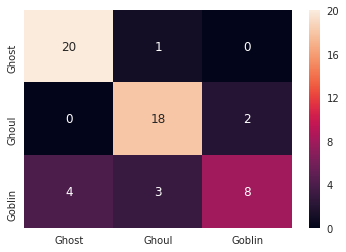

In [22]:
plot_conf(logfit_pred)

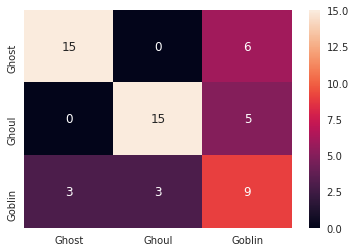

In [23]:
plot_conf(knn_pred)

# 4. Submit to Kaggle 

In [24]:
def submit(clf, name):
    predicts = clf.predict(X_test)
    labels = answers_encoder.inverse_transform(predicts)
    
    answers = pd.DataFrame(data={'id': test.id, 'type': labels})
    answers.to_csv(name + '.csv', index=False)

In [25]:
submit(logfit, 'logfit_poly_degree_' + str(degree))
submit(knn.best_estimator_, 'knn')